In [1]:
from IPython.core.display import display, HTML

display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

### 1. Каким образом в Excel можно сопоставить данные двух таблиц? Напишите примеры формул.

VLOOKUP, INDEX+MATCH, Power Query Merge (jupyter-notebook + pandas люблю значительно сильнее :)

### 2. Вы запускаете рекламную кампанию в Facebook для кредитной карты «Тинькофф Платинум». Какие utm-метки вы будете использовать и зачем? Приведите пример.
https://www.sravni.ru/bank/tinkoff-bank/kreditnaja-karta/mastercardworld/tinkoff-platinum/

* utm_source - для определения источника трафика
* utm_medium - для определения типа трафика
* utm_campaign - для определения типа кампании
* utm_nooverride - для корректного определения первого касания пользователя в Google Analytics - если пользователь, к примеру, перешёл из FB на сайт, потом зарегистрировался, потом только из письма перешел на сайт по ссылке подтверждения регистрации и заказал карту

### 3. Есть таблица с Client Id пользователя и списком событий. Напишите SQL-запрос который выведет список с количеством уникальных событий по каждому пользователю отсортированный по убыванию. 

In [2]:
import sqlite3
import pandas as pd

In [3]:
# Путь к тестовой БД с предзаполненными данными:

db_file = '../resources/sravni_test.db'

In [4]:
def create_connection(db_file):
    """Создает полключение к базе данных sqlite3"""
    try:
        conn = \
            sqlite3.connect(db_file,
                            detect_types=sqlite3.PARSE_DECLTYPES |
                            sqlite3.PARSE_COLNAMES)
        return conn
    except Error as e:
        print(e)

    return None

In [29]:
# Проверим соединение

create_connection(db_file)

In [30]:
def query_db(db_file, sql):
    conn = create_connection(db_file, )
    cursor = conn.cursor()
    query = cursor.execute(sql)
    cols = [column[0] for column in query.description]
    result = pd.DataFrame(query.fetchall(), columns=cols)
    return result

In [31]:
# Посмотрим на формат таблицы:

sql = '''
    SELECT * FROM events LIMIT 50
'''

events = query_db(db_file, sql)
events.head(3)

,client_id,event
0,client_6,event_63
1,client_8,event_14
2,client_8,event_95


In [32]:
# Cделаем выборку количества уникальных событий по пользователю, отсортируем по убыванию:

sql = '''
 SELECT 
     client_id,
     COUNT(DISTINCT event) AS unique_events_cnt
FROM events
GROUP BY 1
ORDER BY 2 DESC
'''
query_db(db_file, sql)

,client_id,unique_events_cnt
0,client_7,72
1,client_5,67
2,client_1,66
3,client_4,65
4,client_6,65
5,client_9,65
6,client_3,62
7,client_0,60
8,client_2,60
9,client_8,56


### 4. У вас есть две таблицы. Первая (t1) - данные по заявкам на Подбор кредита с сайта Сравни.ру, вторая (t2) - выгрузка банка о выдаче кредита. Напишите SQL-запрос, чтобы узнать, какие пользователи получили кредит.

In [11]:
sql = '''
SELECT
    t1.request_id, 
    t1.surname,
    t2.status
FROM requests t1
JOIN request_result t2 on t1.request_id = t2.request_id
WHERE t2.status = 'Выдан'
'''
query_db(db_file, sql)

,request_id,surname,status
0,4774,Васечкин,Выдан
1,3345,Сидоров,Выдан
2,2335,Иванов,Выдан


### 5. У вас есть две таблицы. Первая (orders) - данные по заявкам на Подбор кредита с сайта Сравни.ру, вторая (users) - справочник с контактными данными пользователей. Напишите SQL-запрос, чтобы найти id заявок и фамилии пользователей с самым большим значением в поле amount для каждого из пользователей женского пола. Для удобства по ссылке ниже вы найдёте запрос создающий таблицы с тестовыми данными. *
https://docs.google.com/document/d/1O4NEXb9Ge7TBIarPj9DyJg7I4Y6d7CPRV1Y_tv0pKmc/

In [33]:
# Сделаем это через оконную функцию row_number():

sql = '''
WITH ords AS (
SELECT
    *,
    row_number() OVER (PARTITION BY phone ORDER BY amount DESC) AS r_n
FROM orders o)
SELECT
    id, surname, sex, amount as max_amount
FROM ords
JOIN users u ON u.phone = ords.phone
WHERE ords.r_n = 1 AND u.sex = 'woman'

'''
query_db(db_file, sql)

,id,surname,sex,max_amount
0,6560,Зуева,woman,17500


### 6. По ссылке ниже вы найдёте 2 .xslx файла, в которых содержатся данные об отправках писем и о конверсиях в заказы из этих писем. С помощью Power BI постройте график, на котором по дням отобразите динамику CR из уникального клика в заказ. Отдельным элементом покажите средний CR из уникального клика в заказ за весь выбранный период, а также сделайте 2 фильтра: по дате и по типу продукта. Готовую визуализацию в формате .pbix загрузите на любой файлообменник, а в поле ответа укажите ссылку. *
https://drive.google.com/drive/folders/1tai87LBJvMeTLDSETWXa9YDmYYZZYeEQ

In [13]:
orders = pd.read_excel('../resources/Orders.xlsx')
mails = pd.read_excel('../resources/Mails.xlsx')

In [14]:
orders.head(3)

,date,product,orders,revenue
0,2019-11-01,Партнёрский продукт,0,0.00
1,2019-11-01,Партнёрский продукт,60,343.06
2,2019-11-01,Страховой продукт,36,4089.60


In [15]:
mails.head(3)

,date,product,sent,opens,uniqueOpens,clicks,uniqueClicks,unsubscribes
0,2019-11-01,Финансовый продукт,209,225,97,71,49,1
1,2019-11-01,Финансовый продукт,1010,651,282,135,95,1
2,2019-11-01,Финансовый продукт,46,71,22,26,15,0


In [16]:
# Сгруппируем orders по product - выше видим, что уникальные продукты представлены лишь типом, а не уникальным названием

orders_gr = orders.groupby(by=['date', 'product']).agg({'orders':'sum', 'revenue':'sum'}).reset_index()

In [17]:
# Сделаем аналогично для mails:

mails_gr = mails.groupby(by=['date', 'product']).agg({'sent':'sum', 'opens':'sum', 'uniqueOpens':'sum',
                                          'clicks':'sum', 'uniqueClicks':'sum',
                                          'unsubscribes': 'sum'}).reset_index()

In [18]:
# Соберем mails и orders в один датасет:

res = pd.merge(orders_gr, mails_gr, on=['date', 'product'])

In [19]:
# Рассчитаем метрику CR:

res['CR'] = round(res['orders'] / res['uniqueClicks'], 2)

In [20]:
# Сохраним датасет в xlsx для дальнейшего построения дашборда в Power BI Web

res.to_excel('data_for_dash.xlsx', index=False)

#### Получившийся график так же можно посмотреть по ссылке: 
https://app.powerbi.com/groups/me/reports/4e5d31c2-02cc-4501-a06a-5e08de602174?ctid=7f642a40-3476-4c35-96c8-909a073928cd

In [27]:
# Встрою получившийся график как iframe, т.к. пользуюсь Mac OS и сейчас нет возможности экспорта в .pbix:
# К слову, прекрасно работает и здесь:)

from IPython.display import IFrame
IFrame("https://app.powerbi.com/reportEmbed?reportId=4e5d31c2-02cc-4501-a06a-5e08de602174&autoAuth=true&ctid=7f642a40-3476-4c35-96c8-909a073928cd&config=eyJjbHVzdGVyVXJsIjoiaHR0cHM6Ly93YWJpLXdlc3QtZXVyb3BlLXJlZGlyZWN0LmFuYWx5c2lzLndpbmRvd3MubmV0LyJ9",
      width=1140, height=540)

### 7. Напишите скрипт на Python, получающий данные из HTML таблицы с данными по рождаемости в России (ссылка ниже) и визуализируйте их на графике. Готовый файл в формате .ipynb загрузите на любой файлообменник, а в поле ответа укажите ссылку. *
https://worldtable.info/gosudarstvo/tablica-rozhdaemosti-po-godam-rossija.html

In [23]:
import bs4 as bs
import urllib.request
import pandas as pd

# Откроем адрес и спарсим элемент table с помощью bs4:

source = urllib.request.urlopen('https://worldtable.info/gosudarstvo/tablica-rozhdaemosti-po-godam-rossija.html').read()
soup = bs.BeautifulSoup(source,'html')
birth_table = soup.find('table')
rows = birth_table.find_all('tr')

# Соберем элементы таблицы в список:

l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)

In [24]:
# Преобразуем полученный список в датафрейм:

birth_df = pd.DataFrame(l[1:], columns=l[0])
birth_df['Количество родившихся чел.'] = birth_df['Количество родившихся чел.'].apply(lambda x: float(x.replace(' ', '')))
birth_df.tail(3)

,Год,Количество родившихся чел.
58,2017,1689884.0
59,2018,1599316.0
60,2019,1484517.0


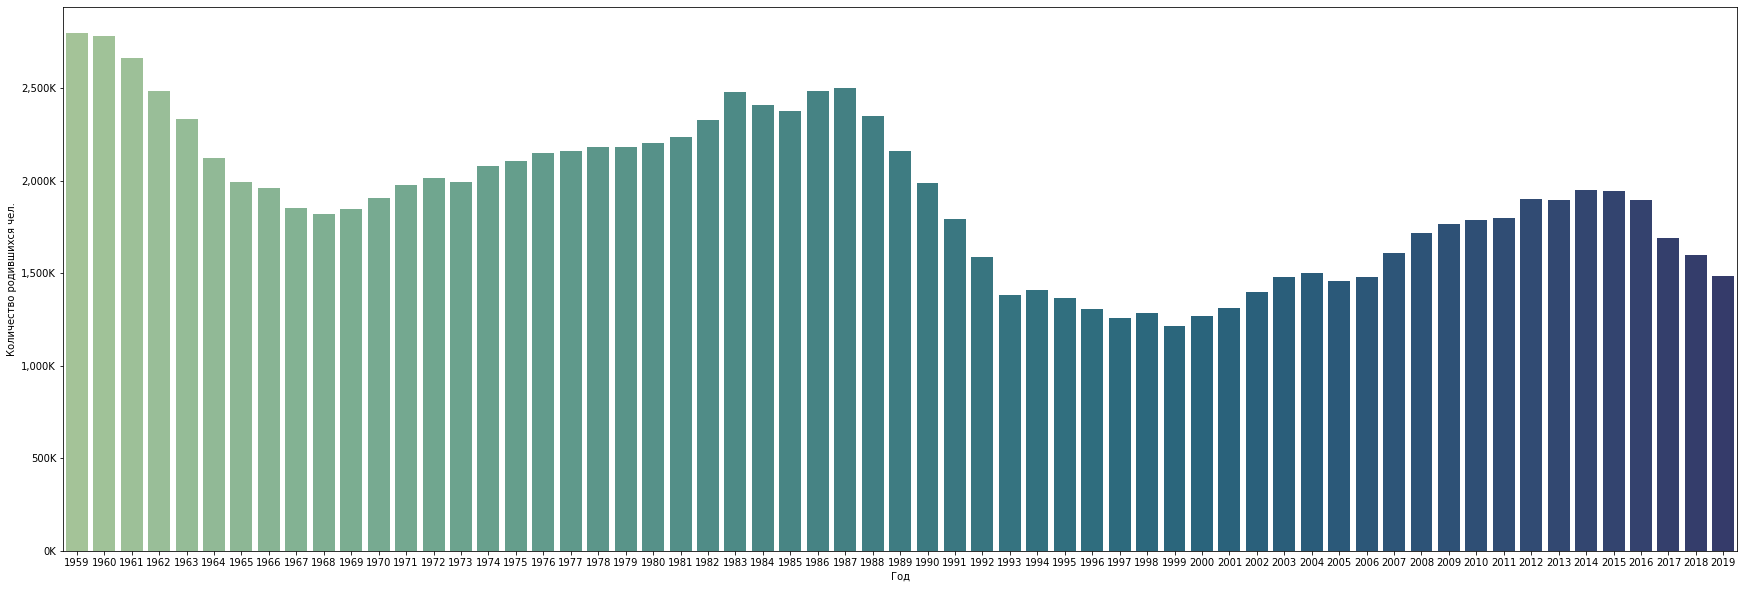

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Визуализируем полученный датафрейм с помощью seaborn:

plt.figure(figsize=(30,10))
g = sns.barplot(x='Год', y='Количество родившихся чел.', data=birth_df, palette='crest')
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.show()